In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images


from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.layers import Cropping2D, UpSampling2D
from keras.utils import to_categorical
#from keras.utils import np_utils

# Required for loss function
import math
from tensorflow.python.keras import losses

#from tensorflow.contrib.keras.layers import Cropping2D

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Import the data

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\Swain_lab\\train\\'
TEST_PATH = 'F:\\MA\\data\\Swain_lab\\test\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

In [4]:
# Define pre-process function

from skimage.transform import resize

def pre_process(img, img_height, img_width, norm = False, rescale = False, mask = False):
    img = np.array(img)                 #list to array
    proc_img = []
    
    #proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        
    if mask:
        proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    else:
        proc_img = img[:,:,np.newaxis]
        proc_img = resize(img, (img_height, img_width, 1), mode='constant', preserve_range=True)
        
    if rescale:
        proc_img /= 255
        
    #image normalization
    if norm:
        #adjusted_std = max(np.std(proc_img), 1.0/np.sqrt(proc_img.size))
        ipsilon = 0.0001
        proc_img = (proc_img-np.mean(proc_img))/np.std(proc_img)+ipsilon
        
    return proc_img

In [6]:
# Test for pre_process
'''
id_ = train_ids[random.randint(0, len(train_ids))]
print(id_)
test_img = imread(TRAIN_PATH + 'in/' + id_)
print('Original Image')
test_img1 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT)
imshow(np.reshape(test_img1, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Rescale')
test_img2 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, rescale = True)
imshow(np.reshape(test_img2, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Normalization')
test_img3 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True)
imshow(np.reshape(test_img3, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Both')
test_img4 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True, rescale = True)
imshow(np.reshape(test_img4, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
'''

"\nid_ = train_ids[random.randint(0, len(train_ids))]\nprint(id_)\ntest_img = imread(TRAIN_PATH + 'in/' + id_)\nprint('Original Image')\ntest_img1 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT)\nimshow(np.reshape(test_img1, (IMG_WIDTH, IMG_HEIGHT)))\nplt.show()\n\nprint('Rescale')\ntest_img2 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, rescale = True)\nimshow(np.reshape(test_img2, (IMG_WIDTH, IMG_HEIGHT)))\nplt.show()\n\nprint('Normalization')\ntest_img3 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True)\nimshow(np.reshape(test_img3, (IMG_WIDTH, IMG_HEIGHT)))\nplt.show()\n\nprint('Both')\ntest_img4 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True, rescale = True)\nimshow(np.reshape(test_img4, (IMG_WIDTH, IMG_HEIGHT)))\nplt.show()\n"

In [7]:
# Get and resize train images and masks
# X: original images, Y: masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    img = imread(TRAIN_PATH + 'in/' + id_)
    X_train[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TRAIN_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_train[n] = mask
    
    
# Get and resize test images
#sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:01<00:00, 82.72it/s]


Getting and resizing test images ... 


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 112.72it/s]


Done!


In [8]:
print(X_train.shape)
print(Y_train.shape)

(104, 128, 128, 1)
(104, 128, 128, 3)


63


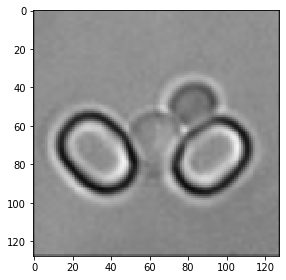

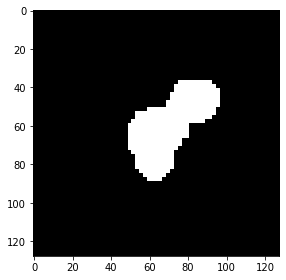

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids)-1)
print(ix)
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_train[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_train[ix,:,:,mask_category])
plt.show()

41


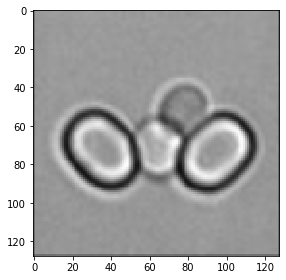

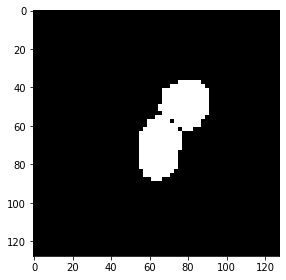

In [10]:
# Check if test data looks all right
ix = random.randint(0, len(test_ids)-1)
print(ix)
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_test[ix,:,:,mask_category]) 
plt.show()

In [11]:
def IoU(y_true,y_pred):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = intersection / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))
    return score

def IoU_loss(y_true , y_pred):
    loss = 1 - IoU(y_true, y_pred)
    return loss

In [12]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 0
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [13]:
# Define cropping function for UNet
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [19]:
# Build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

# Preprocess is conducted directly in dataset
#s = Lambda(lambda x: x / 255) (inputs)
s = inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

###################

#u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = UpSampling2D(size=(2, 2))(c5)

ch, cw = get_crop_shape(c4, u6)
crop_c4 = Cropping2D(cropping=(ch,cw))(c4)

u6 = concatenate([u6, crop_c4]) # Need to crop c4 from 64 to 56
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


#u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = UpSampling2D(size=(2, 2))(c6)

ch, cw = get_crop_shape(c3, u7)
crop_c3 = Cropping2D(cropping=(ch,cw))(c3)

u7 = concatenate([u7, crop_c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)


#u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = UpSampling2D(size=(2, 2))(c7)

ch, cw = get_crop_shape(c2, u8)
crop_c2 = Cropping2D(cropping=(ch,cw))(c2)

u8 = concatenate([u8, crop_c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


#u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = UpSampling2D(size=(2, 2))(c8)

ch, cw = get_crop_shape(c1, u9)
crop_c1 = Cropping2D(cropping=(ch,cw))(c1)

u9 = concatenate([u9, crop_c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(filters=LABEL_CLASS, kernel_size=(1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss ='binary_crossentropy', metrics = [dice_loss, 'accuracy', IoU])
model.compile(optimizer='adam', loss = bce_dice_loss, metrics = [dice_loss, 'accuracy', IoU])
#model.compile(optimizer='adam', loss = IoU_loss, metrics = [IoU, dice_loss, 'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 16) 2320        dropout_19[0][0]                 
__________________________________________________________________________________________________
max_poolin

up_sampling2d_12 (UpSampling2D) (None, 128, 128, 32) 0           conv2d_54[0][0]                  
__________________________________________________________________________________________________
cropping2d_12 (Cropping2D)      (None, 128, 128, 16) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 128, 128, 48) 0           up_sampling2d_12[0][0]           
                                                                 cropping2d_12[0][0]              
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 128, 128, 16) 6928        concatenate_12[0][0]             
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_55[0][0]                  
__________

In [21]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-Swain-unet-softmax.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Train on 93 samples, validate on 11 samples
Epoch 1/50
93/93 [==============================] - ETA: 15s - loss: 0.6730 - dice_loss: 0.2062 - acc: 0.8523 - IoU: 0.39 - ETA: 12s - loss: 0.6966 - dice_loss: 0.2043 - acc: 0.8524 - IoU: 0.39 - ETA: 10s - loss: 0.6757 - dice_loss: 0.1969 - acc: 0.8586 - IoU: 0.40 - ETA: 8s - loss: 0.6706 - dice_loss: 0.1945 - acc: 0.8595 - IoU: 0.4028 - ETA: 7s - loss: 0.6661 - dice_loss: 0.1922 - acc: 0.8610 - IoU: 0.403 - ETA: 6s - loss: 0.6643 - dice_loss: 0.1910 - acc: 0.8612 - IoU: 0.404 - ETA: 5s - loss: 0.6674 - dice_loss: 0.1915 - acc: 0.8592 - IoU: 0.404 - ETA: 4s - loss: 0.6612 - dice_loss: 0.1904 - acc: 0.8604 - IoU: 0.404 - ETA: 2s - loss: 0.6582 - dice_loss: 0.1900 - acc: 0.8614 - IoU: 0.405 - ETA: 1s - loss: 0.6491 - dice_loss: 0.1884 - acc: 0.8641 - IoU: 0.405 - ETA: 0s - loss: 0.6446 - dice_loss: 0.1872 - acc: 0.8657 - IoU: 0.406 - 13s 144ms/step - loss: 0.6403 - dice_loss: 0.1863 - acc: 0.8666 - IoU: 0.4068 - val_loss: 0.9944 - val_dice_los

93/93 [==============================] - ETA: 11s - loss: 0.4022 - dice_loss: 0.1015 - acc: 0.9243 - IoU: 0.44 - ETA: 10s - loss: 0.3579 - dice_loss: 0.0934 - acc: 0.9341 - IoU: 0.45 - ETA: 9s - loss: 0.3400 - dice_loss: 0.0911 - acc: 0.9372 - IoU: 0.4545 - ETA: 8s - loss: 0.3414 - dice_loss: 0.0926 - acc: 0.9361 - IoU: 0.453 - ETA: 7s - loss: 0.3451 - dice_loss: 0.0943 - acc: 0.9347 - IoU: 0.452 - ETA: 6s - loss: 0.3468 - dice_loss: 0.0965 - acc: 0.9328 - IoU: 0.451 - ETA: 4s - loss: 0.3426 - dice_loss: 0.0960 - acc: 0.9330 - IoU: 0.452 - ETA: 3s - loss: 0.3432 - dice_loss: 0.0957 - acc: 0.9322 - IoU: 0.452 - ETA: 2s - loss: 0.3389 - dice_loss: 0.0944 - acc: 0.9327 - IoU: 0.452 - ETA: 1s - loss: 0.3442 - dice_loss: 0.0945 - acc: 0.9324 - IoU: 0.452 - ETA: 0s - loss: 0.3442 - dice_loss: 0.0947 - acc: 0.9318 - IoU: 0.452 - 13s 140ms/step - loss: 0.3438 - dice_loss: 0.0947 - acc: 0.9318 - IoU: 0.4526 - val_loss: 0.4781 - val_dice_loss: 0.0867 - val_acc: 0.9346 - val_IoU: 0.4567

Epoch 00

93/93 [==============================] - ETA: 12s - loss: 0.3303 - dice_loss: 0.0992 - acc: 0.9233 - IoU: 0.45 - ETA: 10s - loss: 0.2994 - dice_loss: 0.0861 - acc: 0.9364 - IoU: 0.45 - ETA: 9s - loss: 0.2850 - dice_loss: 0.0803 - acc: 0.9423 - IoU: 0.4598 - ETA: 8s - loss: 0.2784 - dice_loss: 0.0769 - acc: 0.9464 - IoU: 0.461 - ETA: 7s - loss: 0.2770 - dice_loss: 0.0752 - acc: 0.9464 - IoU: 0.462 - ETA: 6s - loss: 0.2733 - dice_loss: 0.0732 - acc: 0.9479 - IoU: 0.463 - ETA: 5s - loss: 0.2792 - dice_loss: 0.0743 - acc: 0.9465 - IoU: 0.462 - ETA: 4s - loss: 0.2796 - dice_loss: 0.0749 - acc: 0.9460 - IoU: 0.462 - ETA: 2s - loss: 0.2762 - dice_loss: 0.0745 - acc: 0.9463 - IoU: 0.462 - ETA: 1s - loss: 0.2782 - dice_loss: 0.0748 - acc: 0.9459 - IoU: 0.462 - ETA: 0s - loss: 0.2829 - dice_loss: 0.0755 - acc: 0.9454 - IoU: 0.462 - 13s 143ms/step - loss: 0.2824 - dice_loss: 0.0757 - acc: 0.9454 - IoU: 0.4622 - val_loss: 0.3768 - val_dice_loss: 0.0872 - val_acc: 0.9338 - val_IoU: 0.4564

Epoch 00

93/93 [==============================] - ETA: 11s - loss: 0.2459 - dice_loss: 0.0643 - acc: 0.9521 - IoU: 0.46 - ETA: 10s - loss: 0.2415 - dice_loss: 0.0655 - acc: 0.9480 - IoU: 0.46 - ETA: 9s - loss: 0.2512 - dice_loss: 0.0691 - acc: 0.9449 - IoU: 0.4655 - ETA: 8s - loss: 0.2472 - dice_loss: 0.0672 - acc: 0.9466 - IoU: 0.466 - ETA: 7s - loss: 0.2441 - dice_loss: 0.0651 - acc: 0.9492 - IoU: 0.467 - ETA: 6s - loss: 0.2436 - dice_loss: 0.0646 - acc: 0.9499 - IoU: 0.467 - ETA: 5s - loss: 0.2395 - dice_loss: 0.0632 - acc: 0.9520 - IoU: 0.468 - ETA: 3s - loss: 0.2383 - dice_loss: 0.0630 - acc: 0.9525 - IoU: 0.468 - ETA: 2s - loss: 0.2379 - dice_loss: 0.0628 - acc: 0.9525 - IoU: 0.468 - ETA: 1s - loss: 0.2372 - dice_loss: 0.0630 - acc: 0.9523 - IoU: 0.468 - ETA: 0s - loss: 0.2370 - dice_loss: 0.0632 - acc: 0.9522 - IoU: 0.468 - 13s 141ms/step - loss: 0.2383 - dice_loss: 0.0636 - acc: 0.9517 - IoU: 0.4682 - val_loss: 0.2622 - val_dice_loss: 0.0623 - val_acc: 0.9577 - val_IoU: 0.4688

Epoch 00

93/93 [==============================] - ETA: 11s - loss: 0.2071 - dice_loss: 0.0527 - acc: 0.9612 - IoU: 0.47 - ETA: 10s - loss: 0.2116 - dice_loss: 0.0542 - acc: 0.9608 - IoU: 0.47 - ETA: 9s - loss: 0.2100 - dice_loss: 0.0541 - acc: 0.9599 - IoU: 0.4729 - ETA: 8s - loss: 0.2120 - dice_loss: 0.0544 - acc: 0.9591 - IoU: 0.472 - ETA: 7s - loss: 0.2134 - dice_loss: 0.0550 - acc: 0.9583 - IoU: 0.472 - ETA: 6s - loss: 0.2108 - dice_loss: 0.0545 - acc: 0.9593 - IoU: 0.472 - ETA: 5s - loss: 0.2140 - dice_loss: 0.0555 - acc: 0.9590 - IoU: 0.472 - ETA: 3s - loss: 0.2162 - dice_loss: 0.0564 - acc: 0.9583 - IoU: 0.471 - ETA: 2s - loss: 0.2177 - dice_loss: 0.0571 - acc: 0.9581 - IoU: 0.471 - ETA: 1s - loss: 0.2170 - dice_loss: 0.0571 - acc: 0.9583 - IoU: 0.471 - ETA: 0s - loss: 0.2172 - dice_loss: 0.0573 - acc: 0.9578 - IoU: 0.471 - 13s 144ms/step - loss: 0.2167 - dice_loss: 0.0572 - acc: 0.9581 - IoU: 0.4714 - val_loss: 0.2398 - val_dice_loss: 0.0573 - val_acc: 0.9596 - val_IoU: 0.4714

Epoch 00

93/93 [==============================] - ETA: 11s - loss: 0.2081 - dice_loss: 0.0569 - acc: 0.9519 - IoU: 0.47 - ETA: 10s - loss: 0.2065 - dice_loss: 0.0560 - acc: 0.9562 - IoU: 0.47 - ETA: 9s - loss: 0.2078 - dice_loss: 0.0558 - acc: 0.9576 - IoU: 0.4721 - ETA: 8s - loss: 0.2032 - dice_loss: 0.0546 - acc: 0.9591 - IoU: 0.472 - ETA: 7s - loss: 0.2039 - dice_loss: 0.0547 - acc: 0.9587 - IoU: 0.472 - ETA: 6s - loss: 0.2033 - dice_loss: 0.0542 - acc: 0.9596 - IoU: 0.472 - ETA: 5s - loss: 0.2031 - dice_loss: 0.0540 - acc: 0.9599 - IoU: 0.473 - ETA: 4s - loss: 0.2052 - dice_loss: 0.0540 - acc: 0.9602 - IoU: 0.473 - ETA: 2s - loss: 0.2033 - dice_loss: 0.0533 - acc: 0.9605 - IoU: 0.473 - ETA: 1s - loss: 0.2025 - dice_loss: 0.0530 - acc: 0.9605 - IoU: 0.473 - ETA: 0s - loss: 0.2038 - dice_loss: 0.0531 - acc: 0.9600 - IoU: 0.473 - 13s 145ms/step - loss: 0.2026 - dice_loss: 0.0528 - acc: 0.9600 - IoU: 0.4736 - val_loss: 0.2350 - val_dice_loss: 0.0555 - val_acc: 0.9598 - val_IoU: 0.4722

Epoch 00

93/93 [==============================] - ETA: 11s - loss: 0.2150 - dice_loss: 0.0567 - acc: 0.9600 - IoU: 0.47 - ETA: 10s - loss: 0.2073 - dice_loss: 0.0552 - acc: 0.9559 - IoU: 0.47 - ETA: 9s - loss: 0.2024 - dice_loss: 0.0535 - acc: 0.9554 - IoU: 0.4732 - ETA: 8s - loss: 0.2044 - dice_loss: 0.0538 - acc: 0.9538 - IoU: 0.473 - ETA: 7s - loss: 0.2057 - dice_loss: 0.0540 - acc: 0.9537 - IoU: 0.473 - ETA: 6s - loss: 0.2051 - dice_loss: 0.0535 - acc: 0.9540 - IoU: 0.473 - ETA: 5s - loss: 0.2028 - dice_loss: 0.0527 - acc: 0.9552 - IoU: 0.473 - ETA: 3s - loss: 0.2037 - dice_loss: 0.0525 - acc: 0.9560 - IoU: 0.473 - ETA: 2s - loss: 0.2066 - dice_loss: 0.0527 - acc: 0.9572 - IoU: 0.473 - ETA: 1s - loss: 0.2043 - dice_loss: 0.0522 - acc: 0.9580 - IoU: 0.473 - ETA: 0s - loss: 0.2019 - dice_loss: 0.0519 - acc: 0.9585 - IoU: 0.474 - 13s 143ms/step - loss: 0.2029 - dice_loss: 0.0522 - acc: 0.9585 - IoU: 0.4739 - val_loss: 0.2360 - val_dice_loss: 0.0575 - val_acc: 0.9612 - val_IoU: 0.4713

Epoch 00

93/93 [==============================] - ETA: 12s - loss: 0.1974 - dice_loss: 0.0485 - acc: 0.9635 - IoU: 0.47 - ETA: 10s - loss: 0.1954 - dice_loss: 0.0487 - acc: 0.9604 - IoU: 0.47 - ETA: 9s - loss: 0.1923 - dice_loss: 0.0484 - acc: 0.9607 - IoU: 0.4758 - ETA: 8s - loss: 0.1896 - dice_loss: 0.0481 - acc: 0.9610 - IoU: 0.476 - ETA: 7s - loss: 0.1910 - dice_loss: 0.0486 - acc: 0.9614 - IoU: 0.475 - ETA: 6s - loss: 0.1900 - dice_loss: 0.0484 - acc: 0.9622 - IoU: 0.475 - ETA: 5s - loss: 0.1898 - dice_loss: 0.0484 - acc: 0.9625 - IoU: 0.475 - ETA: 4s - loss: 0.1906 - dice_loss: 0.0487 - acc: 0.9630 - IoU: 0.475 - ETA: 2s - loss: 0.1894 - dice_loss: 0.0486 - acc: 0.9633 - IoU: 0.475 - ETA: 1s - loss: 0.1909 - dice_loss: 0.0491 - acc: 0.9625 - IoU: 0.475 - ETA: 0s - loss: 0.1897 - dice_loss: 0.0488 - acc: 0.9624 - IoU: 0.475 - 14s 146ms/step - loss: 0.1902 - dice_loss: 0.0491 - acc: 0.9623 - IoU: 0.4755 - val_loss: 0.2212 - val_dice_loss: 0.0521 - val_acc: 0.9603 - val_IoU: 0.4739

Epoch 00

In [16]:
# evaluate the model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)

#print(train_loss)
#print(test_loss)

In [17]:
print(train_loss)
print(test_loss)

[0.2535850084744967, 0.06149160861968994, 0.8742470374474158, 0.46925419569015503]
[0.2955423524746528, 0.06830459374647874, 0.8724928635817307, 0.4658477031267606]


In [35]:
type(history)
history.history

{'val_loss': [0.8019381761550903,
  0.7179739276568095,
  0.6447404623031616,
  0.6422608097394308,
  0.6110568443934122,
  0.469166765610377,
  0.5224011540412903,
  0.4159757395585378,
  0.5635402897993723,
  0.3077075978120168,
  0.23278738061587015,
  0.2957045336564382,
  0.22635463873545328,
  0.2371053546667099,
  0.1763507773478826,
  0.18649366994698843,
  0.19255465269088745,
  0.1814650148153305,
  0.18611091375350952,
  0.16709351042906442,
  0.16809122761090597,
  0.16835804283618927,
  0.1847617675860723,
  0.1828450212876002,
  0.1619274765253067,
  0.15639866391817728,
  0.2311179836591085,
  0.18630707263946533,
  0.1510485808054606,
  0.17650192975997925,
  0.16926157474517822,
  0.15649928152561188,
  0.18778574963410696,
  0.1612928013006846],
 'val_dice_loss': [0.2726811170578003,
  0.2176178296407064,
  0.20777634779612222,
  0.15566299359003702,
  0.14232343435287476,
  0.1314343810081482,
  0.15394105513890585,
  0.13551847139994302,
  0.117250661055247,
  0.086

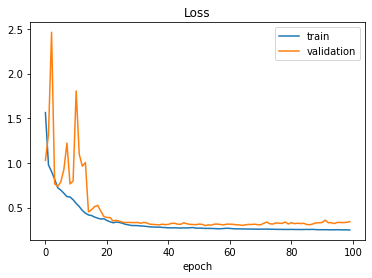

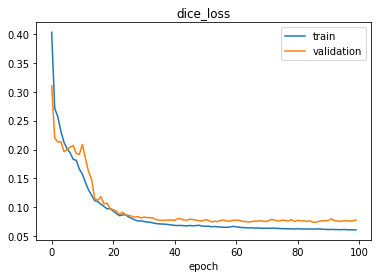

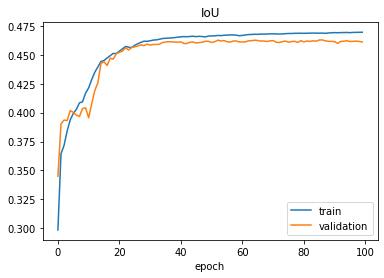

In [19]:
# plot loss during training
plt.title('Loss')
#train_loss = history.history['loss']
#test_loss = history.history['val_loss']
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
#plt.show()
plt.savefig('result_loss.png')

# plot dice_loss during training
plt.figure()
plt.title('dice_loss')
plt.plot(history.history['dice_loss'], label='train')
plt.plot(history.history['val_dice_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
#plt.show()
plt.savefig('result_dice.png')

# plot IoU during training
plt.figure()
plt.title('IoU')
plt.plot(history.history['IoU'], label='train')
plt.plot(history.history['val_IoU'], label='validation')
plt.xlabel('epoch')
plt.legend()
#plt.show()
plt.savefig('result_iou.png')

#plt.savefig('result.png')